Total packets: 25938
Unique senders: 49
       sendtime       rcvtime  senderID  messageID  \
0  25200.003363  25200.003478       262        854   
1  25200.007104  25200.007217        34       1100   
2  25200.009710  25200.009819       130       1348   
3  25200.012893  25200.013007        94       1622   
4  25200.013522  25200.013639        70       1778   

                                       position  \
0    [5732.167012765934, 4891.38384378471, 0.0]   
1  [5750.435148911961, 4888.8054415518545, 0.0]   
2   [5745.959105265088, 4893.973772397958, 0.0]   
3  [5735.823659478266, 4912.1616541037265, 0.0]   
4   [5715.576089835176, 4920.804825525684, 0.0]   

                                            speed   heading  ddostype  msgtype  
0                                 [0.0, 0.0, 0.0] -2.775642         0        0  
1                                [-0.0, 0.0, 0.0] -2.775642         0        0  
2                                [-0.0, 0.0, 0.0] -2.775642         0        0  
3  [

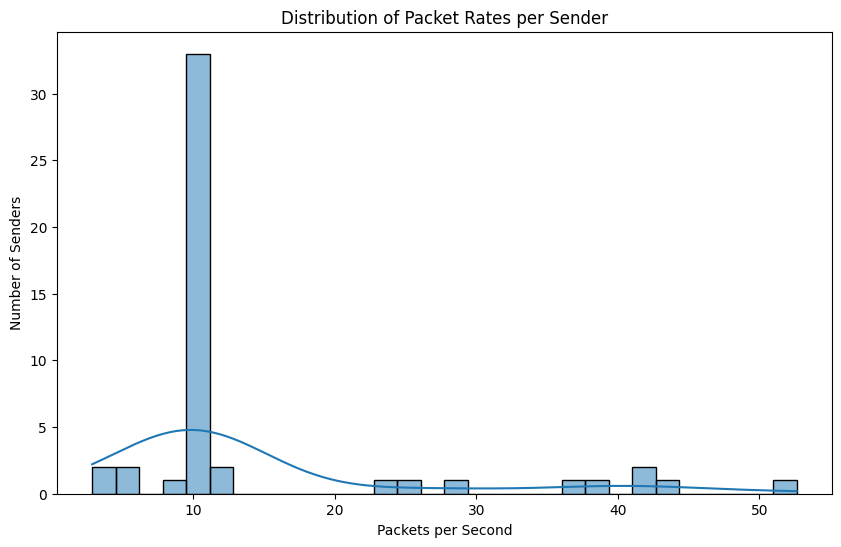

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = 'Dataset_pkt_16.json'

with open(file_path, 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# === Basic Info ===
print("Total packets:", len(df))
print("Unique senders:", df['senderID'].nunique())
print(df.head())

# === Add latency column ===
df['latency'] = df['rcvtime'] - df['sendtime']

# === Sender-level aggregation ===
sender_stats = df.groupby('senderID').agg(
    total_packets=('messageID', 'count'),
    avg_latency=('latency', 'mean'),
    std_latency=('latency', 'std'),
    first_send=('sendtime', 'min'),
    last_send=('sendtime', 'max'),
).reset_index()

# === Calculate rate per sender (pkts/sec) ===
sender_stats['duration'] = sender_stats['last_send'] - sender_stats['first_send']
sender_stats['pkt_rate'] = sender_stats['total_packets'] / sender_stats['duration'].replace(0, 1e-6)

# === Sort by packet rate ===
top_senders = sender_stats.sort_values(by='pkt_rate', ascending=False)

print("\nTop senders by packet rate:")
print(top_senders.head())

# === Plotting ===
plt.figure(figsize=(10, 6))
sns.histplot(sender_stats['pkt_rate'], bins=30, kde=True)
plt.title("Distribution of Packet Rates per Sender")
plt.xlabel("Packets per Second")
plt.ylabel("Number of Senders")
plt.show()


In [2]:
import json
import pandas as pd
import numpy as np

# === Load dataset_pkt_28 ===
with open('dataset_pkt_28.json', 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# === Create latency and rounded time windows ===
df['latency'] = df['rcvtime'] - df['sendtime']
df['rcvtime_rounded'] = df['rcvtime'].apply(lambda x: int(x))  # 1-sec window

# === Aggregate features per 1-second window ===
window_features = df.groupby('rcvtime_rounded').agg(
    received_packets=('messageID', 'count'),
    IAT_Mean=('rcvtime', lambda x: np.mean(np.diff(sorted(x)))),
    IAT_Std=('rcvtime', lambda x: np.std(np.diff(sorted(x)))),
    IAT_Max=('rcvtime', lambda x: np.max(np.diff(sorted(x))) if len(x) > 1 else 0),
    IAT_Min=('rcvtime', lambda x: np.min(np.diff(sorted(x))) if len(x) > 1 else 0),
    received_addresses=('senderID', pd.Series.nunique),
    max_pkt_from_sameId=('senderID', lambda x: x.value_counts().max())
).reset_index().rename(columns={'rcvtime_rounded': 'timewindow'})

print("Sample aggregated window features:")
print(window_features.head())


Sample aggregated window features:
   timewindow  received_packets  IAT_Mean   IAT_Std   IAT_Max   IAT_Min  \
0       25200               160  0.006174  0.006284  0.020491  0.000163   
1       25201               160  0.006174  0.006281  0.020491  0.000163   
2       25202               160  0.006174  0.006282  0.020491  0.000163   
3       25203               150  0.006588  0.006285  0.020491  0.000202   
4       25204               130  0.007608  0.006213  0.020491  0.001201   

   received_addresses  max_pkt_from_sameId  
0                  16                   10  
1                  16                   10  
2                  16                   10  
3                  15                   10  
4                  13                   10  


c:\Users\Chirag\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Chirag\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Chirag\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Chirag\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Chirag\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type

In [3]:
import json
import pandas as pd
import numpy as np

# === Step 1: Load dataset_pkt_28 ===
with open('Dataset_pkt_28.json', 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# === Step 2: Create latency and time window columns ===
df['latency'] = df['rcvtime'] - df['sendtime']
df['rcvtime_rounded'] = df['rcvtime'].apply(lambda x: int(x))  # 1-second bins

# === Step 3: Aggregate features per window ===
window_features = df.groupby('rcvtime_rounded').agg(
    received_packets=('messageID', 'count'),
    IAT_Mean=('rcvtime', lambda x: np.mean(np.diff(sorted(x))) if len(x) > 1 else 0),
    IAT_Std=('rcvtime', lambda x: np.std(np.diff(sorted(x))) if len(x) > 1 else 0),
    IAT_Max=('rcvtime', lambda x: np.max(np.diff(sorted(x))) if len(x) > 1 else 0),
    IAT_Min=('rcvtime', lambda x: np.min(np.diff(sorted(x))) if len(x) > 1 else 0),
    received_addresses=('senderID', pd.Series.nunique),
    max_pkt_from_sameId=('senderID', lambda x: x.value_counts().max())
).reset_index().rename(columns={'rcvtime_rounded': 'timewindow'})

# === Step 4: Label windows if any packet had ddostype > 0 ===
# Create label dataframe
df['is_attack'] = df['ddostype'].apply(lambda x: 1 if x > 0 else 0)

window_labels = df.groupby('rcvtime_rounded')['is_attack'].max().reset_index()
window_labels = window_labels.rename(columns={'rcvtime_rounded': 'timewindow', 'is_attack': 'has_attacker'})

# === Step 5: Merge features with labels ===
window_features_labeled = pd.merge(window_features, window_labels, on='timewindow', how='left')
window_features_labeled['has_attacker'] = window_features_labeled['has_attacker'].fillna(0).astype(int)

print("✅ Final labeled window feature dataset:")
print(window_features_labeled.head())

# === (Optional) Save to CSV for ML training ===
window_features_labeled.to_csv('window_features_labeled_pkt28.csv', index=False)


✅ Final labeled window feature dataset:
   timewindow  received_packets  IAT_Mean   IAT_Std   IAT_Max   IAT_Min  \
0       25200               160  0.006174  0.006284  0.020491  0.000163   
1       25201               160  0.006174  0.006281  0.020491  0.000163   
2       25202               160  0.006174  0.006282  0.020491  0.000163   
3       25203               150  0.006588  0.006285  0.020491  0.000202   
4       25204               130  0.007608  0.006213  0.020491  0.001201   

   received_addresses  max_pkt_from_sameId  has_attacker  
0                  16                   10             0  
1                  16                   10             0  
2                  16                   10             0  
3                  15                   10             0  
4                  13                   10             0  
